# LENS2
#### Correlations with MOV indices - for CONUS sub-domains

##### Samar Minallah (minallah@ucar.edu)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import shapefile
import csv
import os

from eofs.xarray import Eof
import xeofs as xe

import cftime
import nc_time_axis

ModuleNotFoundError: No module named 'xarray'

## DOMAIN

<div>
<img src="./NOAA_US_cliamte_regions.png" width="700"/>
</div>



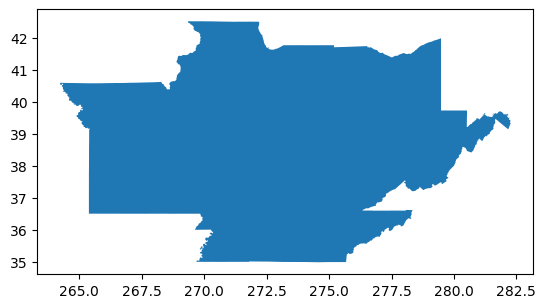

In [10]:
import shapely.ops

shapefiles = [
    'US_Northeast.shp', 'US_NorthernRockies.shp', 'US_Northwest.shp', 'US_OhioValley.shp', 'US_South.shp', 
    'US_Southeast.shp', 'US_Southwest.shp', 'US_UpperMidwest.shp', 'US_West.shp'
]

shapefile_dir = '/glade/campaign/cgd/ccr/minallah/Data/Shapefiles/'

# Shift -180 to 180 longitudes to 0 to 360 - match with LENS2
def shift_geometry_longitudes(geometry):
    def shift_point(lon, lat):
        return ((lon + 360) if lon < 0 else lon, lat)

    return geometry.apply(lambda geom: shapely.ops.transform(
        lambda x, y: shift_point(x, y), geom)
    )

# Read shapefiles and shift longitudes
gdfs = []
for shapefile in shapefiles:
    gdf = gpd.read_file(os.path.join(shapefile_dir, shapefile))
    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')                                 # Double check if this is the right projection for LENS
    gdf['geometry'] = shift_geometry_longitudes(gdf['geometry'])
    gdfs.append(gdf)

# Assign each region
US_NE = gdfs[0]
US_Rockies = gdfs[1]
US_NW = gdfs[2]
US_Ohio = gdfs[3]
US_South = gdfs[4]
US_SE = gdfs[5]
US_SW = gdfs[6]
US_MW = gdfs[7]
US_West = gdfs[8]

input_domain_name = "US_Ohio"
input_domain = US_Ohio
# input_domain = gpd.GeoDataFrame(pd.concat([US_West, US_NW], ignore_index=True))           #If want to combine multiple regions

input_domain.plot();

## READ DATA

In [11]:
ds_VAR = xr.open_dataset('/glade/campaign/cgd/ccr/minallah/Data/Teleconnection_indices/Computed/LENS2_processed_TREFHT_annual_1900_2020.nc')

LESN2_VAR_fgres = ds_VAR.fgresVAR_annual
LESN2_VAR_internal = ds_VAR.iVAR_annual
LESN2_VAR_detrended = ds_VAR.detrendedVAR_annual

## DATA PROCESSING

In [12]:
# Mask the data

variables = [LESN2_VAR_fgres, LESN2_VAR_internal, LESN2_VAR_detrended]
variable_domain_timeseries_list = []

for variable in variables:
    # Rename dimensions to match what rioxarray expects
    variable = variable.rename({'lat': 'y', 'lon': 'x'})

    # Assign CRS
    variable.rio.write_crs('EPSG:4326', inplace=True)

    # Clip using shapefile geometry
    variable_domain = variable.rio.clip(
        input_domain.geometry.apply(mapping),
        input_domain.crs,
        all_touched=False             #Select all gridcells touching the shapefile bounds or not
    )

    # Calculate the mean time series (over spatial dims)
    variable_domain_timeseries = variable_domain.mean(['y', 'x'])

    # Store result
    variable_domain_timeseries_list.append(variable_domain_timeseries)

# Assign back to variables (correcting list index: starts from 0)
LESN2_VAR_fgres_domain = variable_domain_timeseries_list[0].transpose('time','member')
LESN2_VAR_internal_domain = variable_domain_timeseries_list[1].transpose('time','member')
LESN2_VAR_detrended_domain = variable_domain_timeseries_list[2].transpose('time','member')

## PLOTS

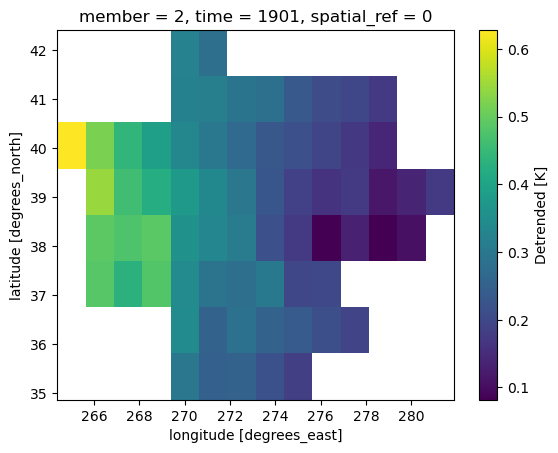

In [13]:
variable_domain[1,:,:,1].plot();           #These are the grid cells within the shapefile bounds. Change all_touched option above if needed